In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd drive/MyDrive/Sapienza/DL

/content/drive/MyDrive/Sapienza/DL


In [3]:

import pickle
import pandas as pd
import numpy as np
import json
import itertools
import gensim
path="SEMEVAL-2021-task6-corpus/data/"


In [4]:
with open('training_task3_images.pkl', 'rb') as handle:
    images = pickle.load(handle)

with open('training_task3_texts.pkl', 'rb') as handle:
    texts = pickle.load(handle)

with open('training_task3_labels_onehot.pkl', 'rb') as handle:
    train_labs = pickle.load(handle)

with open('training_task3_labels_string.pkl', 'rb') as handle:
    train_labs_str = pickle.load(handle)

with open('task3_all_labels.pkl', 'rb') as handle:
    all_labs = pickle.load(handle)



with open('dev_task3_images.pkl', 'rb') as handle:
    dev_images = pickle.load(handle)

with open('dev_task3_texts.pkl', 'rb') as handle:
    dev_texts = pickle.load(handle)

with open('dev_task3_labels_onehot.pkl', 'rb') as handle:
    dev_labs = pickle.load(handle)

with open('dev_task3_labels_string.pkl', 'rb') as handle:
    dev_labs_str = pickle.load(handle)



In [5]:
images=images/255.0
dev_images=dev_images/255.0

In [6]:
from tensorflow.keras.applications import ResNet50
from keras.layers import Dense, GlobalAveragePooling2D
# create the base pre-trained model
base_model = ResNet50(weights='imagenet', include_top=False)


In [7]:
from keras.regularizers import l1
from keras.layers import Dropout, Dense
from keras.models import Model

reg = l1(0.001)

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2) (x)
x = Dense(512, activation='relu', name='feats')(x)
x = Dropout(0.2) (x)
predictions = Dense(train_labs.shape[1], activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.summary()

for layer in base_model.layers:
    layer.trainable = False


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 conv1_conv (Conv2D)            (None, None, None,   9472        ['conv1_pad[0][0]']              
                                64)                                                           

In [8]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['categorical_accuracy', 'accuracy'])

In [9]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

es = EarlyStopping(monitor='val_categorical_accuracy', mode='max', verbose=1, patience=5)

# train for finetuning
history=model.fit(images, train_labs,
                    epochs=60,
                    validation_data=(dev_images, dev_labs),
                  batch_size=8
                  , callbacks=[es]
                  )

Epoch 1/60
86/86 [==============================] - 10s 51ms/step - loss: 0.2939 - categorical_accuracy: 0.2096 - accuracy: 0.2096 - val_loss: 0.2932 - val_categorical_accuracy: 0.0317 - val_accuracy: 0.0317
Epoch 2/60
86/86 [==============================] - 3s 35ms/step - loss: 0.2661 - categorical_accuracy: 0.2242 - accuracy: 0.2242 - val_loss: 0.2807 - val_categorical_accuracy: 0.1587 - val_accuracy: 0.1587
Epoch 3/60
86/86 [==============================] - 3s 34ms/step - loss: 0.2622 - categorical_accuracy: 0.2329 - accuracy: 0.2329 - val_loss: 0.2761 - val_categorical_accuracy: 0.1587 - val_accuracy: 0.1587
Epoch 4/60
86/86 [==============================] - 3s 34ms/step - loss: 0.2603 - categorical_accuracy: 0.2300 - accuracy: 0.2300 - val_loss: 0.2816 - val_categorical_accuracy: 0.1587 - val_accuracy: 0.1587
Epoch 5/60
86/86 [==============================] - 3s 36ms/step - loss: 0.2588 - categorical_accuracy: 0.2358 - accuracy: 0.2358 - val_loss: 0.2808 - val_categorical_accu

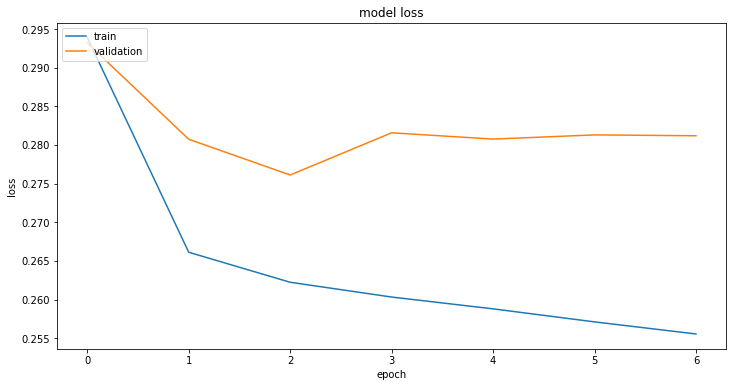

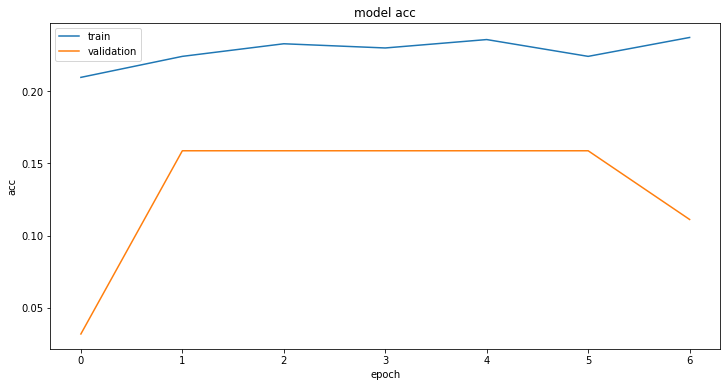

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline


# plotting the validation and training loss i.e. "mean absolute error"
plt.figure(figsize=(12,6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.figure(figsize=(12,6))

plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])

plt.title('model acc')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()


In [11]:
from keras.models import Model

feature_network = Model(model.input, model.get_layer('feats').output)
X_train = feature_network.predict(images)

X_train.shape

(687, 512)

In [12]:
X_valid = feature_network.predict(dev_images)
X_valid.shape

(63, 512)

In [13]:
y_train=train_labs
y_valid=dev_labs

In [14]:
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_auc_score

log_reg = LogisticRegression(C = 10, penalty='l2', solver = 'liblinear', random_state=42)

one_vs_rest = OneVsRestClassifier(log_reg)
one_vs_rest.fit(X_train, y_train)

y_train_pred_proba = one_vs_rest.predict_proba(X_train)
y_valid_pred_proba = one_vs_rest.predict_proba(X_valid)

y_pred = (y_train_pred_proba > 0.3) 
y_train_new=(y_train > 0.3) 

print("Training accuracy: ", accuracy_score(y_train_new, y_pred))

y_pred1 = (y_valid_pred_proba > 0.3) 
y_dev_new=(y_valid > 0.3) 

print("Validation Accuracy: ", accuracy_score(y_dev_new, y_pred1))

from sklearn.metrics import classification_report, f1_score

print("Weighted F1 score: ", f1_score(y_dev_new,y_pred1,average='weighted'))
print("Micro F1 score: ", f1_score(y_dev_new,y_pred1,average='micro'))
print("Macro F1 score: ", f1_score(y_dev_new,y_pred1,average='macro'))

Training accuracy:  0.1717612809315866
Validation Accuracy:  0.1111111111111111
Weighted F1 score:  0.456253783912733
Micro F1 score:  0.5577464788732394
Macro F1 score:  0.11989572489050662


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


In [15]:
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_auc_score

log_reg = LogisticRegression(C = 1, penalty='l2', solver = 'liblinear', random_state=42)

one_vs_rest = OneVsRestClassifier(log_reg)
one_vs_rest.fit(X_train, y_train)

y_train_pred_proba = one_vs_rest.predict_proba(X_train)
y_valid_pred_proba = one_vs_rest.predict_proba(X_valid)

y_pred = (y_train_pred_proba > 0.2) 
y_train_new=(y_train > 0.2) 

print("Training accuracy: ", accuracy_score(y_train_new, y_pred))

y_pred1 = (y_valid_pred_proba > 0.2) 
y_dev_new=(y_valid > 0.2) 

print("Validation Accuracy: ", accuracy_score(y_dev_new, y_pred1))

from sklearn.metrics import classification_report, f1_score

print("Weighted F1 score: ", f1_score(y_dev_new,y_pred1,average='weighted'))
print("Micro F1 score: ", f1_score(y_dev_new,y_pred1,average='micro'))
print("Macro F1 score: ", f1_score(y_dev_new,y_pred1,average='macro'))

Training accuracy:  0.09170305676855896
Validation Accuracy:  0.15873015873015872
Weighted F1 score:  0.4915296105850431
Micro F1 score:  0.58
Macro F1 score:  0.14900608742850463


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


In [16]:
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_auc_score

log_reg = LogisticRegression(C = 20, penalty='l2', solver = 'lbfgs', random_state=42)

one_vs_rest = OneVsRestClassifier(log_reg)
one_vs_rest.fit(X_train, y_train)

y_train_pred_proba = one_vs_rest.predict_proba(X_train)
y_valid_pred_proba = one_vs_rest.predict_proba(X_valid)

y_pred = (y_train_pred_proba > 0.2) 
y_train_new=(y_train > 0.2) 

print("Training accuracy: ", accuracy_score(y_train_new, y_pred))

y_pred1 = (y_valid_pred_proba > 0.2) 
y_dev_new=(y_valid > 0.2) 

print("Validation Accuracy: ", accuracy_score(y_dev_new, y_pred1))

from sklearn.metrics import classification_report, f1_score

print("Weighted F1 score: ", f1_score(y_dev_new,y_pred1,average='weighted'))
print("Micro F1 score: ", f1_score(y_dev_new,y_pred1,average='micro'))
print("Macro F1 score: ", f1_score(y_dev_new,y_pred1,average='macro'))

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Training accuracy:  0.11790393013100436
Validation Accuracy:  0.06349206349206349
Weighted F1 score:  0.49400056923212604
Micro F1 score:  0.5517241379310344
Macro F1 score:  0.15404684056119478


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


In [17]:
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier

rnd = RandomForestClassifier(n_estimators=60,n_jobs=-1)

one_vs_rest = OneVsRestClassifier(rnd)
one_vs_rest.fit(X_train, y_train)

y_train_pred_proba = one_vs_rest.predict_proba(X_train)
y_valid_pred_proba = one_vs_rest.predict_proba(X_valid)

y_pred = (y_train_pred_proba > 0.3) 
y_train_new=(y_train > 0.3) 

print("Training accuracy: ", accuracy_score(y_train_new, y_pred))

y_pred1 = (y_valid_pred_proba > 0.3) 
y_dev_new=(y_valid > 0.3) 

print("Validation Accuracy: ", accuracy_score(y_dev_new, y_pred1))

print("Weighted F1 score: ", f1_score(y_dev_new,y_pred1,average='weighted'))
print("Micro F1 score: ", f1_score(y_dev_new,y_pred1,average='micro'))
print("Macro F1 score: ", f1_score(y_dev_new,y_pred1,average='macro'))

Training accuracy:  0.9461426491994177
Validation Accuracy:  0.1111111111111111
Weighted F1 score:  0.4191559376380979
Micro F1 score:  0.5405405405405405
Macro F1 score:  0.08981031972266272


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
